In [1]:
import os
import time

import json

from operator import itemgetter

# data science imports
import random
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

D:\ProgramData\Anaconda3\envs\venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Load Json Data

In [2]:
def read_josn (path):
    file = open(path, "r", encoding = 'utf-8')
    df = []
    for line in file.readlines():
        dic = json.loads(line)
        df.append(dic)
    return df

In [3]:
# load business data
path = "data/Charlotte/Charlotte_business.json"
business_list = read_josn(path)
# load reviews data
path = "data/Charlotte/Charlotte_Review.json"
review_list = read_josn(path)
# load user data
path = "data/Charlotte/Charlotte_User.json"
user_list = read_josn(path)

## Transform to dataframe

In [4]:
# business list into dataframe
df_business = pd.DataFrame()
business_id = []
name = []
for element in business_list:
    business_id.append(element["business_id"])
    name.append(element["name"])

Business_Num_Id = {}
U = 1
B = 1
Business_Id = []
for index in range(len(business_id)):
    if business_id[index] not in Business_Num_Id.keys():
        Business_Num_Id[business_id[index]] = B
        B = B + 1
    Business_Id.append(Business_Num_Id[business_id[index]])
    

df_business["RawBusinessId"] = business_id
df_business["businessId"] = Business_Id
df_business["title"] = name

df_business.head()

,RawBusinessId,businessId,title
0,gnKjwL_1w79qoiV3IC_xQQ,1,Musashi Japanese Restaurant
1,HhyxOkGAM07SRYtlQ4wMFQ,2,Queen City Plumbing
2,irft4YkdNsww4DNf_Aftew,3,So Cool Frozen Yogurt
3,BvYU3jvGd0TJ7IyZdfiN2Q,4,Manzetti's Tavern
4,Qnz3ywR7BosTr8qDk6G-Pw,5,Mattress Firm Final Markdown


In [5]:
# User list into dataframe
df_user = pd.DataFrame()
user_id = []
name = []
for element in user_list:
    user_id.append(element["user_id"])
    name.append(element["name"])

User_Num_Id = {}
U = 1
User_Id = []
for index in range(len(user_id)):
    if user_id[index] not in User_Num_Id.keys():
        User_Num_Id[user_id[index]] = U
        U = U + 1
    User_Id.append(User_Num_Id[user_id[index]])
    
df_user["RawUserId"] = user_id
df_user["UserId"] = User_Id
df_user["name"] = name

df_user.head()

,RawUserId,UserId,name
0,Ps_zkoSnuv2Gy-QIt0jEJg,1,Lea
1,djQLJTLA4Tx7TpzYCKIqJQ,2,Kris
2,eSlOI3GhroEtcbaD_nFXJQ,3,Jason
3,NmC_ZemjAQ6TvzgeaAuTmA,4,Lindsay
4,gTAMqkDSj8z84XN8YvsSJg,5,Morgan


In [6]:
# review list into dataframe
df_ratings = pd.DataFrame()
#review_id = []
user_id = []
business_id = []
ratings = []
for element in review_list:
    uid = User_Num_Id[element["user_id"]]
    bid = Business_Num_Id[element["business_id"]]
    
    user_id.append(uid)
    business_id.append(bid)
    ratings.append(element["stars"])

#df_ratings["review_id"] = review_id
df_ratings["userId"] = user_id
df_ratings["businessId"] = business_id
df_ratings["rating"] = ratings

df_ratings.head()

,userId,businessId,rating
0,5282,166,5.0
1,9782,521,1.0
2,5280,166,5.0
3,1934,245,4.0
4,4678,36,5.0


## Filter Data

### For Business

In [7]:
# get rating frequency
df_business_cnt = pd.DataFrame(df_ratings.groupby('businessId').size(), columns=['count'])
df_business_cnt.head()

,count
businessId,
1,178
2,4
3,6
4,18
5,4


In [8]:
# top quantiles of rating counts
df_business_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    1895.0
0.95     139.0
0.90      77.0
0.85      50.0
0.80      36.0
0.75      27.0
0.70      21.0
0.65      17.0
Name: count, dtype: float64

In [9]:
# filter data - movies count less than 20
popularity_thres = 10
popular_business = list(set(df_business_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_business = df_ratings[df_ratings.businessId.isin(popular_business)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular business: ', df_ratings_drop_business.shape)

shape of original ratings data:  (309425, 3)
shape of ratings data after dropping unpopular business:  (285809, 3)


### For Users

In [10]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_business.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,3
2,11
3,11
4,62
5,3


In [11]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    799.0
0.95      9.0
0.90      5.0
0.85      4.0
0.80      3.0
0.75      2.0
0.70      2.0
0.65      2.0
0.60      1.0
0.55      1.0
Name: count, dtype: float64

In [12]:
# filter data
ratings_thres = 3
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_business[df_ratings_drop_business.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular business and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (309425, 3)
shape of ratings data after dropping both unpopular business and inactive users:  (202926, 3)


In [13]:
df_ratings_drop_users.index = list(range(0, df_ratings_drop_users.shape[0]))
df_ratings_drop_users

,userId,businessId,rating
0,5282,166,5.0
1,9782,521,1.0
2,5280,166,5.0
3,1934,245,4.0
4,5385,23,3.0
...,...,...,...
202921,46041,8884,5.0
202922,30031,9133,5.0
202923,8822,9371,5.0
202924,14522,9280,5.0


In [14]:
# the number of users and movies
num_users = len(df_ratings_drop_users.userId.unique())
num_items = len(df_ratings_drop_users.businessId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 20697 unique users and 4688 unique movies in this data set


## Split Data

In [15]:
# split the data - 80% training and 20% test
from sklearn.model_selection import train_test_split
training,test = train_test_split(df_ratings_drop_users, test_size=0.2, stratify=df_ratings_drop_users['userId'],random_state=0)
training.index = list(range(0, training.shape[0]))
print (training)

        userId  businessId  rating
0         2356         680     4.0
1           95        1746     5.0
2         1142        6487     3.0
3        12222        3030     5.0
4        49704        8869     2.0
...        ...         ...     ...
162335    6110        3994     5.0
162336    1880        2093     4.0
162337   34959        7042     1.0
162338    4692         680     5.0
162339    1956        6261     3.0

[162340 rows x 3 columns]


In [16]:
test.index = list(range(0, test.shape[0]))
print(test)

       userId  businessId  rating
0        6063        1746     4.0
1          36         245     4.0
2       38376        7891     5.0
3        3068        3704     5.0
4        5815        4451     4.0
...       ...         ...     ...
40581   14868        5437     5.0
40582   21507        8376     5.0
40583   45837        2282     2.0
40584    7200        1171     3.0
40585      69        2514     3.0

[40586 rows x 3 columns]


## Transform dataframe to dictionary

In [17]:
def get_dic(data):    
    dataDic = {}
    dataDic_len = 0
    # 遍历data的每一行， 把userId, movidId, rating按照{user: {movidId: rating}}的方式存储， 当然定义一个随机种子进行数据集划分
    for ele in data.itertuples():   # 遍历行这里推荐用itertuples， 比iterrows会高效很多
        user, business, rating = getattr(ele, 'userId'), getattr(ele, 'businessId'), getattr(ele, 'rating')

        dataDic.setdefault(user, {})
        dataDic[user][business] = rating
        dataDic_len += 1

    print('dataDic = %s' % dataDic_len)
    return (dataDic, dataDic_len)

dataDic, dataDic_len = get_dic(df_ratings_drop_users)
trainSet, trainSet_len = get_dic(training)
testSet, testSet_len = get_dic(test)

dataDic = 202926
dataDic = 162340
dataDic = 40586


## Get Similarity

In [18]:
def get_sim (dataDic):
    # Calculate the popularity of each business, that is, the total number of times each movie is watched by users.
    business_popular = {}
    for user, businesses in dataDic.items(): 
        for business in businesses:  
            if business not in business_popular:     
                business_popular[business] = 0  
            business_popular[business] += 1

    business_count = len(business_popular)
    print('Total business number = %d' % business_count)


    # business similarity matrix
    print('Build user co-rated business matrix ...')
    business_sim_matrix = {}
    for user, businesses in dataDic.items():
        # one business b1
        for b1 in businesses:           
            # another business b2
            for b2 in businesses:
                if b1 == b2:
                    continue
                business_sim_matrix.setdefault(b1, {})      
                # Set the value of the dictionary to the form of a dictionary
                business_sim_matrix[b1].setdefault(b2, 0)

                # cos-sim molecular
                business_sim_matrix[b1][b2] += businesses[b1]*businesses[b2]

    print('Build user co-rated businesses matrix success!')

    # cos-sim Denominator
    temp_sim = {}
    for user, businesses in dataDic.items():
        for b in businesses:
            if b not in temp_sim:     
                temp_sim[b] = 0  
            temp_sim[b] += math.pow(businesses[b],2)

    # Calculate similarity between businesses
    print('Calculating businesses similarity matrix ...')
    for b1, related_businesses in business_sim_matrix.items():
        for b2, count in related_businesses.items():    
            if temp_sim[b1] == 0 or temp_sim[b2] == 0:
                # the business that no user rated it
                business_sim_matrix[b1][b2] = 0
            else:
                # cos-sim
                business_sim_matrix[b1][b2] = count / math.sqrt(temp_sim[b1] * temp_sim[b2]) 
    print('Calculate businesses similarity matrix success!')
    
    return business_sim_matrix, business_popular

In [19]:
business_sim_matrix, business_popular = get_sim(dataDic)
#business_sim_matrix, business_popular = get_sim(trainSet)

Total business number = 4688
Build user co-rated business matrix ...
Build user co-rated businesses matrix success!
Calculating businesses similarity matrix ...
Calculate businesses similarity matrix success!


In [20]:
# recomend top-N list to users
def recommend(aim_user, data, sim_matrix, k=20, n=20):
    rank ={}
    # find the rated business that traget user rated before
    rated_businesses = data[aim_user]      
    
    # simiarity sum
    w_sum = {}
    
    for business, rating in rated_businesses.items():
        # from rated businessses
        if business not in sim_matrix.keys():
            continue
        for related_business, w in sorted(sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # If the user interacts with this item, skip
            if related_business in rated_businesses:
                continue
            # Calculate the user's preference value for related_business, 
            # and initialize the value to 0
            rank.setdefault(related_business, 0)
            w_sum.setdefault(related_business, 0)
            # weighted the rating and simialrity and record the similarity
            rank[related_business] += w * (rating)
            w_sum[related_business] += w
    
    # predict
    for bid in rank.keys():
        rank[bid] = (rank[bid] / w_sum[bid])
    
    # final list 
    result =  sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]
    # rank position
    rank_position = list(range(1,len(result)+1))
    
    return result, rank_position

#### 一个例子

In [21]:
aim_user = 1202
recom_list, rank_posi = recommend(aim_user, dataDic, business_sim_matrix,k=20,n=20)
#recom_list, rank_posi = recommend(aim_user, trainSet, business_sim_matrix,k=20,n=20)

In [22]:
recom_list

[(2275, 4.0),
 (2842, 4.0),
 (414, 4.0),
 (3512, 4.0),
 (5985, 4.0),
 (5754, 4.0),
 (1977, 4.0),
 (9104, 4.0),
 (1190, 4.0),
 (2933, 4.0),
 (6936, 4.0),
 (1990, 4.0),
 (5185, 4.0),
 (7500, 4.0),
 (3138, 4.0),
 (3458, 4.0),
 (2240, 4.0),
 (2555, 4.0),
 (8242, 4.0),
 (321, 4.0)]

In [23]:
rank_posi

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## PRU

In [24]:
from scipy import stats

def get_SRC(recom_list, rank_posi, business_popular):
    # popularity list
    popularity = []
    for bid, rating in recom_list:
        popularity.append(business_popular[bid])
    
    SRC,_ = stats.spearmanr(rank_posi, popularity)
    
    return SRC    

In [25]:
-get_SRC(recom_list, rank_posi, business_popular)

0.7461452201224567

In [26]:
SRC_list = []
SRC = 0
pop_list = []
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, rank_posi = recommend(uid, dataDic, business_sim_matrix, k = 20, n = 20)
    SRC = get_SRC(recom_list, rank_posi, business_popular)
    SRC_list.append(SRC)
    
PRU = -np.mean(SRC_list)

In [27]:
PRU

-0.028142706303575456

## PRI

In [28]:
ave_rank = {}
rank_count = {}
pop = {}
for uid in list(dataDic.keys()):
    recom_list, rank_posi = recommend(uid, dataDic, business_sim_matrix,k = 20, n = 20)
    for index in range(len(recom_list)):
        bid = recom_list[index][0]
        ave_rank.setdefault(bid,0)
        rank_count.setdefault(bid,0)
        ave_rank[bid] += rank_posi[index]
        rank_count[bid] += 1

for business in ave_rank:
    ave_rank[business] = ave_rank[business]/rank_count[business]
    pop.setdefault(business,0)
    pop[business] = business_popular[business]


SRC,_ = stats.spearmanr(list(ave_rank.values()), list(pop.values()))
PRI = -SRC
PRI

-0.17609718243084477

## Plot Frequency

In [27]:
rec_business_popular = business_popular
rec_freq = {}
for b in rec_business_popular:
    rec_freq.setdefault(b, 0)
    
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, _ = recommend(uid, dataDic, business_sim_matrix,k = 20, n = 20)
    for rec in recom_list:
        rec_freq[rec[0]] += 1

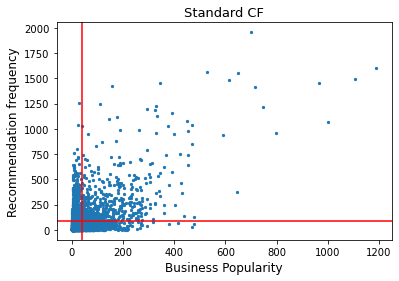

In [28]:
import matplotlib.pyplot as plt

x_popularity = list(rec_business_popular.values())
y_recommendation_frequency = list(rec_freq.values())
pop_mean = np.mean(x_popularity)
rec_mean = np.mean(y_recommendation_frequency)
plt.scatter(x_popularity, y_recommendation_frequency,s=5,marker='o')
plt.axhline(y = rec_mean, color = "r", linestyle = "-")
plt.axvline(x = pop_mean, color = "r", linestyle = "-")

plt.xlabel('Business Popularity',fontsize=12)  
plt.ylabel('Recommendation frequency',fontsize=12)
plt.title('Standard CF', fontsize=13)

plt.savefig('Standard CF in Cha.png')
plt.show()

## Evaluation

In [31]:
# for training set
business_sim_matrix,_ = get_sim(trainSet)

Total business number = 4686
Build user co-rated business matrix ...
Build user co-rated businesses matrix success!
Calculating businesses similarity matrix ...
Calculate businesses similarity matrix success!


In [32]:
def predict (aim_user, aim_bid, business_sim_matrix,data, N):
    pred = 0
    w_sum = 0
    count = 0
    N = 20

    rated_businesses = data[aim_user]
    if aim_bid not in business_sim_matrix.keys():
        return 0
    else:
        cand_list = sorted(business_sim_matrix[aim_bid].items(), key=itemgetter(1), reverse=True)

    for bid, w in cand_list:
        if bid != aim_bid and bid in rated_businesses:
            rating = trainSet[aim_user][bid]
            pred += w * (rating)
            w_sum += w
            count += 1
            if count == N:
                break

    # predict
    if w_sum == 0:
        result = 0
    else:
        result =  (pred / w_sum)
        
    return result

In [33]:
# predicted ratings
pred_ratings = []
N = 20

for index in range(len(test)):
    #print(index)
    uid = test['userId'][index]
    bid = test['businessId'][index]
    pred_ratings.append(predict(uid, bid, business_sim_matrix, trainSet, N))

MSE = np.mean(pow(test["rating"] - pred_ratings, 2))
RMSE = np.sqrt(MSE)
print("The overall RMSE of the test set is ",RMSE)

The overall RMSE of the test set is  1.5484249504193337


# Bias-CF

In [29]:
business_sim_matrix, business_popular = get_sim(dataDic)

Total business number = 4688
Build user co-rated business matrix ...
Build user co-rated businesses matrix success!
Calculating businesses similarity matrix ...
Calculate businesses similarity matrix success!


In [30]:
# get average
avg_rating_overall = 0
avg_rating_users = {}
avg_rating_items = {}
for b in business_popular:
    avg_rating_items.setdefault(b, 0)

for user, businesses in dataDic.items():
    avg_rating_users.setdefault(user, 0)
    avg_rating_users[user] = np.mean(list(businesses.values()))
    avg_rating_overall += sum(businesses.values())
    
    for business in businesses:
        avg_rating_items[business] += businesses[business]

avg_rating_overall = avg_rating_overall/dataDic_len


for user in avg_rating_users:
    avg_rating_users[user] = avg_rating_overall-avg_rating_users[user]

for business in avg_rating_items:
    Mean = avg_rating_items[business]/business_popular[business]
    avg_rating_items[business] = avg_rating_overall - Mean

In [31]:
def recommend_rerank(aim_user, data, sim_matrix, bg, bu, bi, k=20, n=20):
    rank ={}
    rated_businesses = data[aim_user]      # 找出目标用户看到电影

    w_sum = {}
    R = {}
    
    for business, rating in rated_businesses.items():
        #遍历与物品item最相似的前k个产品，获得这些物品及相似分数
        for related_business, w in sorted(sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # 若该物品用户看过， 跳过
            if related_business in rated_businesses:
                continue
            # 计算用户user对related_business的偏好值， 初始化该值为0
            rank.setdefault(related_business, 0)
            w_sum.setdefault(related_business, 0)
            #通过与其相似物品对物品related_business的偏好值相乘并相加。
            #排名的依据—— > 推荐电影与该已看电影的相似度(累计) * 用户对已看电影的评分
            rank[related_business] += w * (rating - (bu[aim_user]+bi[business]+bg))
            w_sum[related_business] += w
    
    # 753
    for bid in rank.keys():
        rank[bid] = (rank[bid] / w_sum[bid]) + (bu[aim_user]+bi[bid]+bg)

    # 产生最后的推荐列表
    result =  sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法
    
    rank_position = list(range(1,len(result)+1))
    
    return result, rank_position

In [32]:
aim_user = 1202
recom_list, rank_posi = recommend_rerank(aim_user, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items,k=20,n=20)

In [33]:
recom_list

[(9104, 5.450294117647059),
 (3407, 5.3580735953299286),
 (7950, 5.1215753424657535),
 (6767, 4.998684556695606),
 (5249, 4.995883436247427),
 (412, 4.950590251332826),
 (2842, 4.896099656357388),
 (8570, 4.802941176470588),
 (1235, 4.782811540822591),
 (5754, 4.711774193548387),
 (7412, 4.649478207489257),
 (3247, 4.60230570040823),
 (1145, 4.58952140476543),
 (1695, 4.558988288410071),
 (1263, 4.531422651933702),
 (6174, 4.520384866275277),
 (6396, 4.503505341269095),
 (3138, 4.492592592592592),
 (1977, 4.47543956043956),
 (5892, 4.475343739649031)]

## PRU

In [43]:
-get_SRC(recom_list, rank_posi, business_popular)

-0.013538925365125222

In [44]:
SRC_list = []
SRC = 0
pop_list = []
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, rank_posi = recommend_rerank(uid, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items, k = 20, n = 20)
    SRC = get_SRC(recom_list, rank_posi, business_popular)

    SRC_list.append(SRC)
    
PRU = -np.mean(SRC_list)
PRU

-0.23396464965638097

## PRI

In [45]:
ave_rank = {}
rank_count = {}
pop = {}
for uid in list(dataDic.keys()):
    recom_list, rank_posi = recommend_rerank(uid, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items, k = 20, n = 20)
    for index in range(len(recom_list)):
        bid = recom_list[index][0]
        ave_rank.setdefault(bid,0)
        rank_count.setdefault(bid,0)
        ave_rank[bid] += rank_posi[index]
        rank_count[bid] += 1

for business in ave_rank:
    ave_rank[business] = ave_rank[business]/rank_count[business]
    pop.setdefault(business,0)
    pop[business] = business_popular[business]


SRC,_ = stats.spearmanr(list(ave_rank.values()), list(pop.values()))
PRI = -SRC
PRI

0.004804753502032158

## Plot frequency

In [34]:
rec_business_popular1 = business_popular
rec_freq1 = {}
for b in rec_business_popular1:
    rec_freq1.setdefault(b, 0)
    
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, _ = recommend_rerank(uid, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items,k=20,n=20)
    for rec in recom_list:
        rec_freq1[rec[0]] += 1

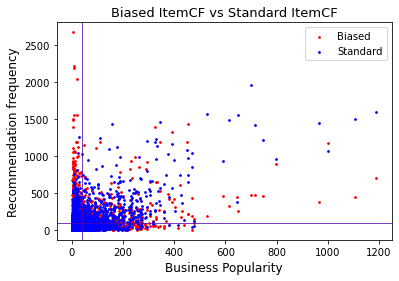

In [38]:
import matplotlib.pyplot as plt

# after
x_popularity = list(rec_business_popular1.values())
y_recommendation_frequency = list(rec_freq1.values())
pop_mean = np.mean(x_popularity)
rec_mean = np.mean(y_recommendation_frequency)
plt.scatter(x_popularity, y_recommendation_frequency,s=3,marker='o', color = 'red', label = "Biased")
plt.axhline(y = rec_mean, color = "r", linestyle = "-",linewidth=0.5)
plt.axvline(x = pop_mean, color = "r", linestyle = "-", linewidth=0.5)

# before
x_popularity = list(rec_business_popular.values())
y_recommendation_frequency = list(rec_freq.values())
pop_mean = np.mean(x_popularity)
rec_mean = np.mean(y_recommendation_frequency)
plt.scatter(x_popularity, y_recommendation_frequency,s=3,marker='o', color = 'blue', label = "Standard")
plt.axhline(y = rec_mean, color = "b", linestyle = "-", linewidth=0.5)
plt.axvline(x = pop_mean, color = "b", linestyle = "-", linewidth=0.5)

plt.legend(loc="best")
plt.xlabel('Business Popularity',fontsize=12)  
plt.ylabel('Recommendation frequency',fontsize=12)
plt.title('Biased ItemCF vs Standard ItemCF', fontsize=13)

plt.savefig('Bias CF in Cha.png')
plt.show()

### Evaluation

In [48]:
# for training set
business_sim_matrix,_ = get_sim(trainSet)

Total business number = 4686
Build user co-rated business matrix ...
Build user co-rated businesses matrix success!
Calculating businesses similarity matrix ...
Calculate businesses similarity matrix success!


In [49]:
def predict_bias (aim_user, aim_bid, business_sim_matrix,data, bg,bu, bi, N):
    pred = 0
    w_sum = 0
    count = 0
    N = 20

    rated_businesses = data[aim_user]
    if aim_bid not in business_sim_matrix.keys():
        return 0
    else:
        cand_list = sorted(business_sim_matrix[aim_bid].items(), key=itemgetter(1), reverse=True)

    for bid, w in cand_list:
        if bid != aim_bid and bid in rated_businesses:
            rating = trainSet[aim_user][bid]
            pred += w * (rating - (bu[aim_user]+bi[bid]+bg))
            w_sum += w
            count += 1
            if count == N:
                break

    # predict
    if w_sum == 0:
        result = 0
    else:
        result =  (pred / w_sum) + (bu[aim_user]+bi[aim_bid]+bg)
        
    return result

In [51]:
# predicted ratings
pred_ratings = []
N = 20

for index in range(len(test)):
    #print(index)
    uid = test['userId'][index]
    bid = test['businessId'][index]
    pred_ratings.append(predict_bias(uid, bid, business_sim_matrix, trainSet, avg_rating_overall, avg_rating_users, avg_rating_items,N))

MSE = np.mean(pow(test["rating"] - pred_ratings, 2))
RMSE = np.sqrt(MSE)
print("The overall RMSE of the test set is ",RMSE)

The overall RMSE of the test set is  1.8184637005246647
